# Introduction

In the first part, we used dd and syscall-related tracepoints and
probes so as to find out the average costs of tracepoints and probes
on our test platform (Intel x86_64 IvyBridge core i7-3537U):

* About 350ns for a static tracepoint;
* About 400ns for a dynamic probe.

In the second part, we tried to find out whether the costs of
tracepoints or probes varies a lot around the average values measured
above:

* 1% of the samples were beyond the double of the average value;
* Most of the preemption cases were not taken into account (the
  unhandled preemption cases: SMI interrupts, etc.)

In this third part, we will briefly try to decompose the costs. Which
part is the most expensive ? The tracepoint code ? Or its
serialization into the ring-buffers ?  etc.

# Description of the test environments

The profiling tests will be executed in the same environment as
before:

*Basic laptop machine*

* CPU: Intel Core i7-3537U @ 2.00GHz (up to 3.10GHz) 1 CPU / 2 cores
  per CPU / 2 threads per core;
* RAM: 8GB;
* System: Arch (glibc-2.23)
* Cpufreq governor: performance: the pstate power scaling driver is
  used; so the CPU frequency cannot be statically set with a
  user-space tool.
```
# cpupower frequency-set -g performance
```

The second set of tests (with a slightly modified kernel) will we be
executed on a virtualized environment:

*Qemu/KVM guest machine*

* Host machine: the "basic laptop machine";
* CPU: 2 emulated/virtualized cores
* RAM: 3GB
* System: generated with buildroot (glibc-2.22, busybox-1.24.1 and
  integrated as an initramfs into the kernel );
* Command line:
```
qemu-system-x86_64 \
    -enable-kvm -cpu host -smp cores=2 \
    -m 3G \
    -nographic -append "console=ttyS0,9600n8" \
    -kernel bzImage 
```

# Step 1: profiling tracepoint/probe-related code

The idea here is very simple: let's launch the commands below and
profile its execution:

*Static tracepoints command*:
```
perf record \
    -e raw_syscalls:sys_enter \
    -- bash -c "time dd if=/dev/zero of=/dev/null bs=1 count=10000000"
```

*Dynamic probes command*:
```
perf record \
    -e probe:sys_read -e probe:sys_write \
    -- bash -c "time dd if=/dev/zero of=/dev/null bs=1 count=10000000"
```

Here are the commands which records the profiling-related samples:
```
perf record \
    -o profiling_raw_syscalls_sys_enter.data \
    -a --call-graph dwarf,4096 \
    -- sleep 10

# perf record \
    -o profiling_kprobe_syscalls_read_write.data \
    -a --call-graph dwarf,4096 \
    -- sleep 10
```

## Results

And here are some partial results:

*Static tracepoints profiling results*:
```
# perf report -i profiling_raw_syscalls_sys_enter.data --stdio
...
47.20%     0.49%  dd               [kernel.vmlinux]             [k] tracesys_phase2
|
---tracesys_phase2
|
|--37.96%--syscall_trace_enter_phase2
|          |
|          |--36.92%--perf_trace_sys_enter
|          |          |
|          |          |--31.57%--perf_tp_event
|          |          |          |
|          |          |          |--30.37%--perf_swevent_event
|          |          |          |          |
|          |          |          |          |--30.09%--perf_swevent_overflow
|          |          |          |          |          |
|          |          |          |          |          |--29.56%--__perf_event_overflow
|          |          |          |          |          |          |
|          |          |          |          |          |          |--28.40%--perf_event_output
|          |          |          |          |          |          |          |
|          |          |          |          |          |          |          |--15.65%--perf_output_sample
|          |          |          |          |          |          |          |          |
|          |          |          |          |          |          |          |          |--8.82%--memcpy_erms
...
```

*Dynamic probe profiling results*:
```
# perf report -i profiling_kprobe_syscalls_read_write.data --stdio
...
50.90%     1.73%  dd               [kernel.vmlinux]             [k] entry_SYSCALL_64_fastpath
|
---entry_SYSCALL_64_fastpath
|
|--25.31%--sys_read
|          |
|          |--19.75%--0x6145
|          |          |
|          |          |--19.66%--ftrace_ops_recurs_func
|          |          |          |
|          |          |          |--19.14%--kprobe_ftrace_handler
|          |          |          |          |
|          |          |          |          |--18.11%--kprobe_dispatcher
|          |          |          |          |          |
|          |          |          |          |          |--16.96%--kprobe_perf_func
|          |          |          |          |          |          |
|          |          |          |          |          |          |--15.18%--perf_tp_event
|          |          |          |          |          |          |          |
|          |          |          |          |          |          |          |--14.56%--perf_swevent_event
|          |          |          |          |          |          |          |          |
|          |          |          |          |          |          |          |          |--14.44%--perf_swevent_overflow
|          |          |          |          |          |          |          |          |          |
|          |          |          |          |          |          |          |          |          |--14.19%--__perf_event_overflow
|          |          |          |          |          |          |          |          |          |          |
|          |          |          |          |          |          |          |          |          |          |--13.64%--perf_event_output
|          |          |          |          |          |          |          |          |          |          |          |
|          |          |          |          |          |          |          |          |          |          |          |--7.36%--perf_output_sample
|          |          |          |          |          |          |          |          |          |          |          |          |
|          |          |          |          |          |          |          |          |          |          |          |          |--4.23%--memcpy_erms
...
```

## Interpretation

Both call-stacks above go through the functions, "perf_tp_event",
"perf_swevent_event", etc. So, whether it is a tracepoint or a probe,
the execution paths converge quickly toward perf_tp_event.

Furthermore, the summarized profiling report below (look at the column
"Children") or the unrolled report above clearly shows that running
tracepoint code (the functions tracesys_phase2,
syscall_trace_enter_phase2 and perf_trace_sys_enter) takes less 5% of
the resources and the serializing code called after perf_tp_event
seems more expensive:
```
Children      Self  Command          Shared Object                Symbol
+   55.87%     0.00%  dd               libc-2.23.so                 [.] __libc_start_main
+   55.87%     0.00%  dd               dd                           [.] 0x0000000000003b19
+   47.20%     0.49%  dd               [kernel.vmlinux]             [k] tracesys_phase2
+   38.03%     1.01%  dd               [kernel.vmlinux]             [k] syscall_trace_enter_phase2
+   36.92%     3.08%  dd               [kernel.vmlinux]             [k] perf_trace_sys_enter
+   31.64%     1.24%  dd               [kernel.vmlinux]             [k] perf_tp_event
+   30.43%     0.25%  dd               [kernel.vmlinux]             [k] perf_swevent_event
+   30.11%     0.49%  dd               [kernel.vmlinux]             [k] perf_swevent_overflow
+   29.64%     0.95%  dd               [kernel.vmlinux]             [k] __perf_event_overflow
+   28.77%     0.00%  dd               dd                           [.] 0x0000000000002d32
+   28.44%     0.93%  dd               [kernel.vmlinux]             [k] perf_event_output
```
To conclude, bringing the samples to userspace is the operation which
makes tracepoints and probes so expensive.

# Step 2: some basic and practical tests to validate the step 1

Let's use the second test environment (*Qemu/KVM guest machine*) so as
to quickly disable some parts of the tracepoint serialization code. We
will try to skip code execution each time deeper in the call-stack:

* Test 1: no tracepoint-related code  disabled;
* Test 2: disable the function perf_swevent_event; nothing will be
  availble in the ring-buffers; they are not even accessed:
```
diff --git a/kernel/events/core.c b/kernel/events/core.c
...
@@ -6554,6 +6562,10 @@ static void perf_swevent_event(struct perf_event *event, u64 nr,
 {
 	struct hw_perf_event *hwc = &event->hw;
 
+#if 1 /* Test no_perf_swevent_event */
+	return;
+#endif /* Test no_perf_swevent_event */
+	
 	local64_add(nr, &event->count);
 
 	if (!regs)
```
* Test 3: (only) disable the function perf_event_output; here, the
  event-throttling management code is run but nothing more:
```
diff --git a/kernel/events/core.c b/kernel/events/core.c
...
@@ -5603,6 +5607,10 @@ void perf_event_output(struct perf_event *event,
 	struct perf_output_handle handle;
 	struct perf_event_header header;
 
+#if 1 /* Test no_perf_event_output */
+	return;
+#endif /* Test no_perf_event_output */
+	
 	/* protect the callchain buffers */
 	rcu_read_lock();
```
* Test 4: skip only the writing of the tracepoints into the
  ring-buffers (header + "payload"):
```
diff --git a/kernel/events/core.c b/kernel/events/core.c
...
@@ -5337,6 +5337,10 @@ void perf_output_sample(struct perf_output_handle *handle,
 {
 	u64 sample_type = data->type;
 
+#if 1 /* Test no_perf_output_sample */
+	return;
+#endif /* Test no_perf_output_sample */
+	
 	perf_output_put(handle, *header);
 
 	if (sample_type & PERF_SAMPLE_IDENTIFIER)
```

## Results

*Test 0: Tracepoint disabled:*
```
# time dd if=/dev/zero of=/dev/null bs=1 count=3000000
3000000+0 records in
3000000+0 records out
real    0m 0.60s
user    0m 0.13s
sys     0m 0.46s
```

*Test 1: Tracepoint raw_syscalls:sys_enter enabled:*
```
# perf record -e raw_syscalls:sys_enter -- sh -c "time dd if=/dev/zero of=/dev/n
ull bs=1 count=3000000"
3000000+0 records in
3000000+0 records out
real    0m 2.65s
user    0m 0.21s
sys     0m 2.43s
[ perf record: Woken up 2746 times to write data ]
[ perf record: Captured and wrote 698.709 MB perf.data (6000130 samples) ]
```

*Test 2: function perf_swevent_event skipped:*
```
# perf record -e raw_syscalls:sys_enter -- sh -c "time dd if=/dev/zero of=/dev/null bs=1 count=3000000"
3000000+0 records in
3000000+0 records out
real    0m 1.09s
user    0m 0.18s
sys     0m 0.91s
[ perf record: Woken up 1 times to write data ]
[ perf record: Captured and wrote 0.002 MB perf.data ]
```

*Test 3: function perf_event_output skipped:*
```
# perf record -e raw_syscalls:sys_enter -- sh -c "time dd if=/dev/zero of=/dev/null bs=1 count=3000000"
3000000+0 records in
3000000+0 records out
real    0m 1.16s
user    0m 0.17s
sys     0m 0.98s
[ perf record: Woken up 1 times to write data ]
[ perf record: Captured and wrote 0.002 MB perf.data ]
```

*Test 4: function perf_output_sample skipped:*
```
# perf record -e raw_syscalls:sys_enter -- sh -c "time dd if=/dev/zero of=/dev/null bs=1 count=3000000"
3000000+0 records in
3000000+0 records out
real    0m 1.72s
user    0m 0.19s
sys     0m 1.53s
[ perf record: Woken up 2733 times to write data ]
0x170 [0]: failed to process type: 0
[ perf record: Captured and wrote 692.559 MB perf.data ]
```

## Pre-requisite import code

In [8]:
import pandas as pd
import matplotlib as mpl

%matplotlib inline

# Use default pandas plot theme
pd.options.display.mpl_style = 'default'

# Additional Matplotlib stuff
mpl.rcParams['font.size'] = 10
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.subplot.bottom'] = .1

## Interpretation

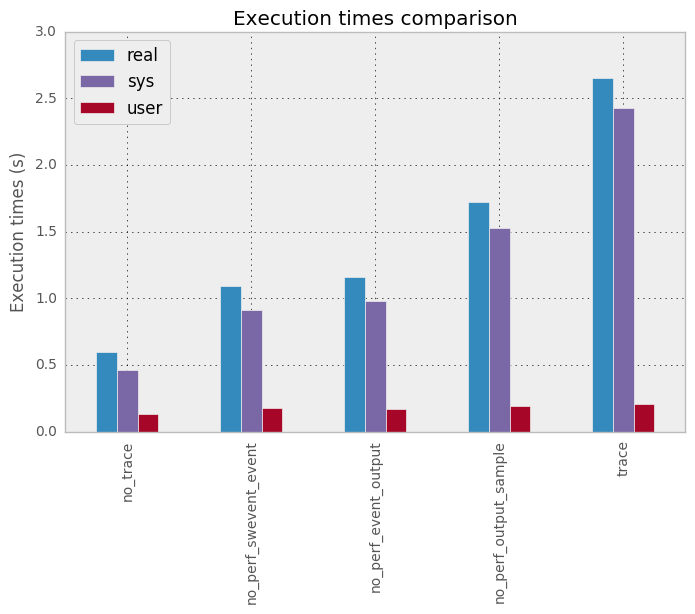

In [9]:
# Let's copy the results above into a pandas dataframe...
test0 = {'real': 0.60, 'user': 0.13, 'sys': 0.46}
test1 = {'real': 2.65, 'user': 0.21, 'sys': 2.43}
test2 = {'real': 1.09, 'user': 0.18, 'sys': 0.91}
test3 = {'real': 1.16, 'user': 0.17, 'sys': 0.98}
test4 = {'real': 1.72, 'user': 0.19, 'sys': 1.53}
names = ['no_trace', 'no_perf_swevent_event',
      	 'no_perf_event_output', 'no_perf_output_sample', 'trace']
df = pd.DataFrame([test0, test2, test3, test4, test1], index=names)

# ...to make a simple bar plot
plot = df.plot(kind='bar', figsize=(8, 5))
plot.set_ylabel('Execution times (s)')
plot.set_title('Execution times comparison')

The first point to note is not related with tracing: the results of dd
in the virtualized environment are really close to those performed in
the host environment. The details on the tests on the host environment
are available in the first document.

The second point is that tracing without forwarding the tracepoint
sample (through the ring-buffers) is far less expensive: only 75ns;
```
(0.91s - 0.46s) / 6000000 = 75ns
```

Finally, copying the samples into the ring-buffer is the most
expensive part; the tests above show that manipulating the ring-buffer
and copying data into it are 2 expensive tasks.

# Conclusion

The cost of a tracepoint was estimated, in the first document, at
350ns; here, we found out such a high value is mostly due to the
sample forwarding (into user-space):

* The tracepoint code (which fills the struct perf_sample_data) costs
  only 75ns;
* The sample serialization code (into the ring-buffers) costs 275ns;

So it would be interesting to find out whether we can reduce the
second and most expensive part; maybe, the cost of using e-bpf is
lower than the cost induced by the ring-buffer manipulation.